<a href="https://colab.research.google.com/github/ayla011/diabetes_prediction_model/blob/main/Who's_at_Risk_of_Diabetes%3F_(with_Prediction_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '100000-diabetes-clinical-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5420190%2F8998172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240817%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240817T140452Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2bbe938cf55274b5a129d8ef43e88291d4887a8fc76c6dfc9603af77a03c1c394407d5545ccc62caebb51c8a97aa4097e28b2f2796090cadf37d562cd2608d5bb1fdf811e20aedb52eea50a23de0deda45e6b3307067a3aed3ddb1a5c5de31de0c522dbc409bbfe27f13f060ea4b856fe8b2c11bdb43c5499754cefea3ff2a1b206ce8a141ea037fca80422eec77876efc9bd311359e8ebc5300b149d4beaff1d9275bfd398409750bc63b60f625a5dd9ab63f7a62ea1caa393909339ec098da9c474dc72b8b5affe40a0576e04d9ac5d73cb279fc5dc60df82932bc614a96f73a89dd7ae7b058c655e1c6759d5a1281c2a796a522c884ed476e8f35882cb2e8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 917848 bytes downloaded
Downloaded and uncompressed: 100000-diabetes-clinical-dataset
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df = pd.read_csv("/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv")

In [4]:
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [6]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# **Exploratory Data Analysis**

<ipython-input-7-3ca0f75bd2e5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(["Non-Diabetic", "Diabetic"])


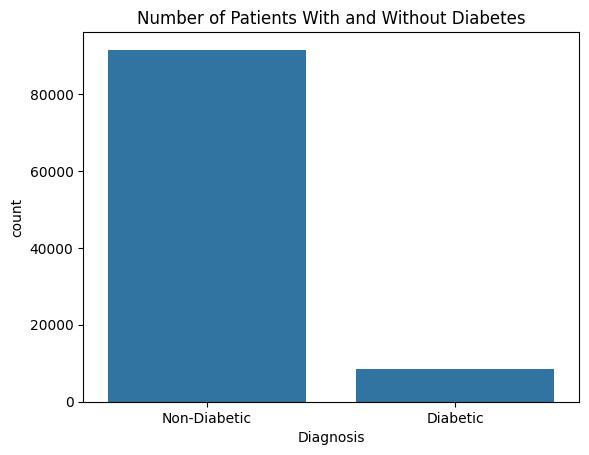

In [7]:
sns.reset_defaults()
d = sns.countplot(data = df, x = "diabetes")
d.set_title("Number of Patients With and Without Diabetes")
d.set_xlabel("Diagnosis")
d.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [8]:
yearly = df.groupby("year")["diabetes"].agg("count").reset_index()
diabetes_yes = df.groupby("year")["diabetes"].agg("sum").reset_index()
yearly = pd.merge(yearly, diabetes_yes, on = "year")
yearly.columns = ["year", "total", "diabetic"]
yearly["non diabetic"] = yearly["total"] - yearly["diabetic"]
yearly.drop("total", axis = 1, inplace = True)

In [9]:
p = df.diabetes.sum()/len(df)*100
print("Percentage of diabetic patients: ", p, "%")

Percentage of diabetic patients:  8.5 %


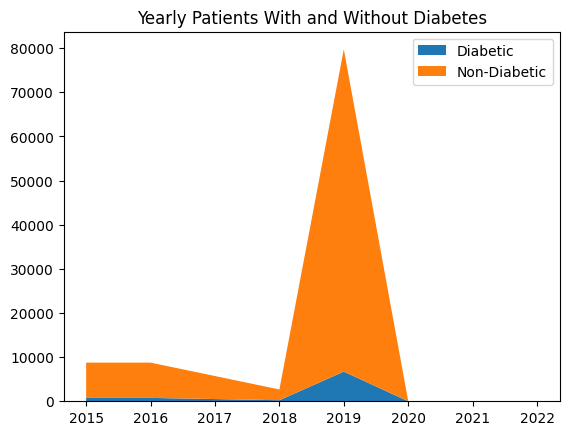

In [10]:
plt.stackplot(yearly["year"], yearly["diabetic"], yearly["non diabetic"], labels = ["Diabetic", "Non-Diabetic"])
plt.title("Yearly Patients With and Without Diabetes")
plt.legend()
plt.show()

<ipython-input-11-15b85ace58ec>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(["Non-Diabetic", "Diabetic"])


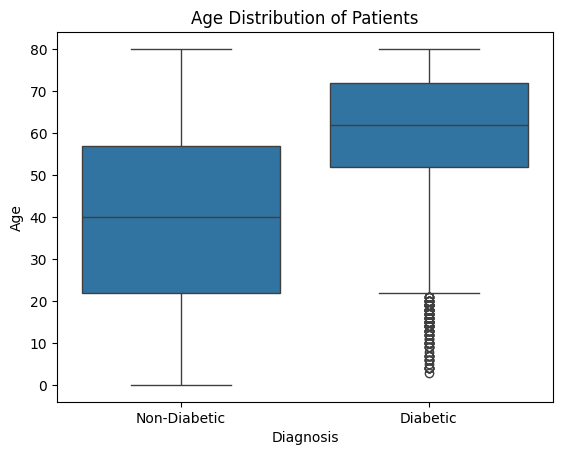

In [11]:
a = sns.boxplot(data = df, x = "diabetes", y = "age")
a.set_title("Age Distribution of Patients")
a.set_xlabel("Diagnosis")
a.set_ylabel("Age")
a.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [12]:
df.age.std()

22.51683987161702

In [13]:
loc = df.location.value_counts(dropna = False).reset_index()
loc

,location,count
0,Iowa,2038
1,Nebraska,2038
2,Kentucky,2038
3,Hawaii,2038
4,Florida,2037
5,Minnesota,2037
6,New Jersey,2037
7,Arkansas,2037
8,Delaware,2036
9,Kansas,2036


In [14]:
dloc = df.groupby("location")["diabetes"].agg("sum").reset_index().sort_values("diabetes", ascending = False)
dloc

,location,diabetes
7,Delaware,200
17,Kansas,199
14,Illinois,195
27,Montana,194
41,Rhode Island,192
18,Kentucky,192
12,Hawaii,186
32,New Mexico,184
25,Mississippi,184
21,Maryland,184


In [15]:
df_race = df[["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"]]
by_race = pd.from_dummies(df_race)
df2 = df.drop(columns = ["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"])
df2.insert(2, "race", by_race)
df2["race"] = df2["race"].str.replace("race:", "")
df2["race"] = df2["race"].str.replace("AfricanAmerican", "African-American")

In [16]:
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
names = ["0-18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
df2.insert(3, "age_cat", pd.cut(df2["age"], bins, labels = names))

In [17]:
bins = [0, 18.5, 25, 30, np.inf]
names = ["Underweight", "Normal", "Overweight", "Obese"]
df2.insert(9, "bmi_cat", pd.cut(df2["bmi"], bins, labels = names))

In [18]:
df2["smoking_history"] = df2["smoking_history"].str.title()

In [19]:
columns = ['gender', 'race', 'age_cat', 'location', 'hypertension','heart_disease', 'smoking_history', 'bmi_cat', 'diabetes']

for col in columns:
    if col in ['gender', 'race', 'age_cat', 'location', 'smoking_history', 'bmi_cat']:
        df2[col] = df2[col].astype("category")
    else:
        df2[col] = df2[col].astype("bool")

In [20]:
columns = list(df2.columns)
new_name = [col.title() for col in columns]

for c, n in zip(columns, new_name):
    df2 = df2.rename(columns = {c:n})

df2 = df2.rename(columns = {"Age_Cat":"Age Group",
                            "Heart_Disease":"Heart Disease",
                            "Smoking_History":"Smoking History",
                            "Bmi_Cat":"BMI Category",
                            "Bmi":"BMI",
                            "Hba1C_Level":"HbA1C Level",
                            "Blood_Glucose_Level":"Blood Glucose Level"
                           }
                )
df2

,Year,Gender,Race,Age Group,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2020,Female,Other,25-34,32.0,Alabama,False,False,Never,Overweight,27.32,5.0,100,False
1,2015,Female,Asian,25-34,29.0,Alabama,False,False,Never,Normal,19.95,5.0,90,False
2,2015,Male,Other,0-18,18.0,Alabama,False,False,Never,Normal,23.76,4.8,160,False
3,2015,Male,Caucasian,35-44,41.0,Alabama,False,False,Never,Overweight,27.32,4.0,159,False
4,2016,Female,African-American,45-54,52.0,Alabama,False,False,Never,Normal,23.75,6.5,90,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,Female,Other,25-34,33.0,Wyoming,False,False,Never,Normal,21.21,6.5,90,False
99996,2016,Female,Asian,65+,80.0,Wyoming,False,False,No Info,Obese,36.66,5.7,100,False
99997,2018,Male,Asian,45-54,46.0,Wyoming,False,False,Ever,Obese,36.12,6.2,158,False
99998,2018,Female,African-American,45-54,51.0,Wyoming,False,False,Not Current,Overweight,29.29,6.0,155,False


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Year                 100000 non-null  int64   
 1   Gender               100000 non-null  category
 2   Race                 100000 non-null  category
 3   Age Group            100000 non-null  category
 4   Age                  100000 non-null  float64 
 5   Location             100000 non-null  category
 6   Hypertension         100000 non-null  bool    
 7   Heart Disease        100000 non-null  bool    
 8   Smoking History      100000 non-null  category
 9   BMI Category         100000 non-null  category
 10  BMI                  100000 non-null  float64 
 11  HbA1C Level          100000 non-null  float64 
 12  Blood Glucose Level  100000 non-null  int64   
 13  Diabetes             100000 non-null  bool    
dtypes: bool(3), category(6), float64(3), int64(2)
memory 

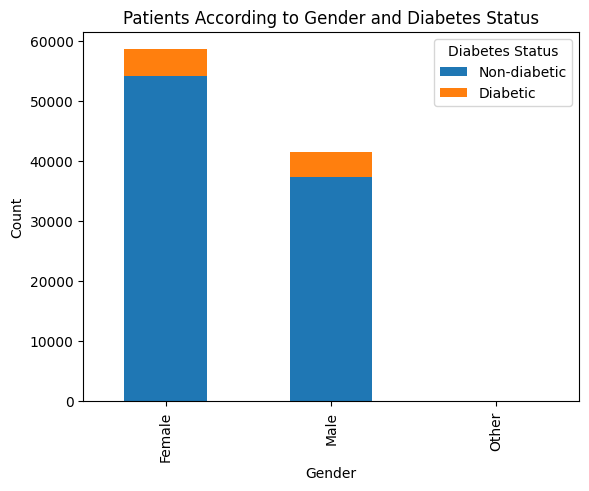

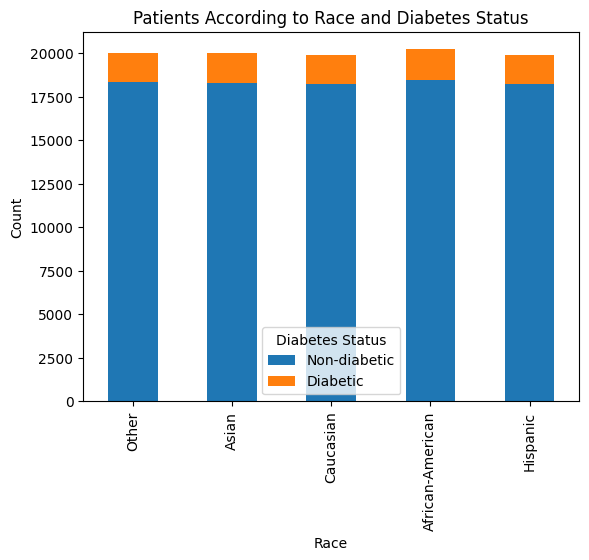

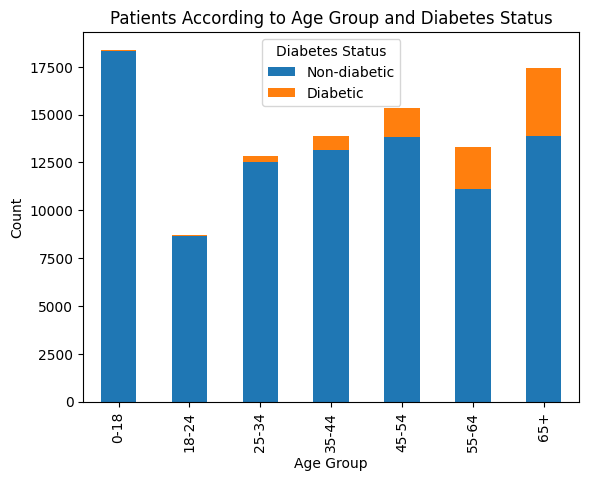

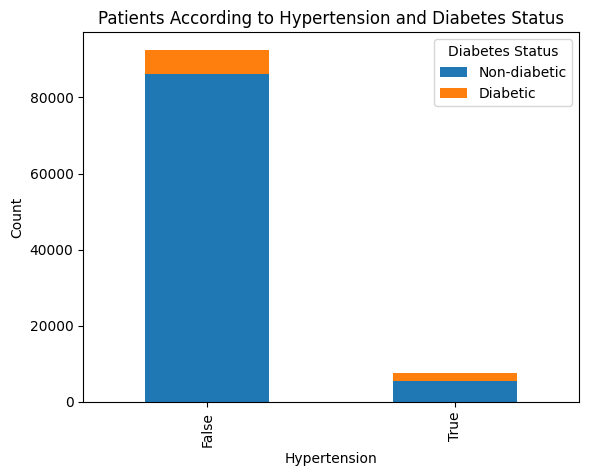

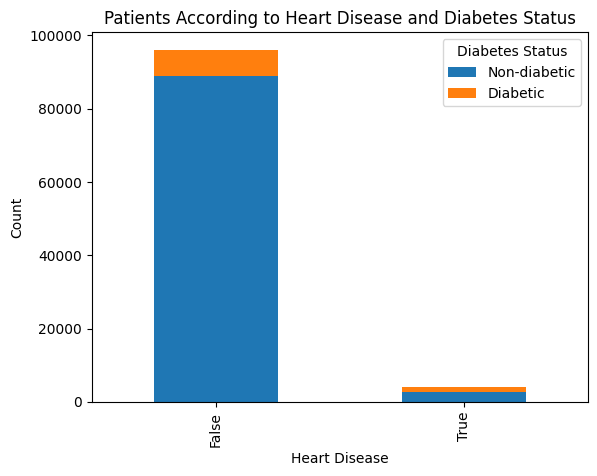

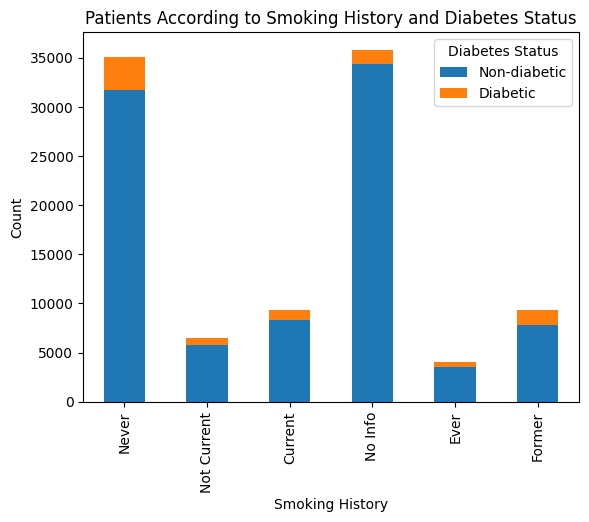

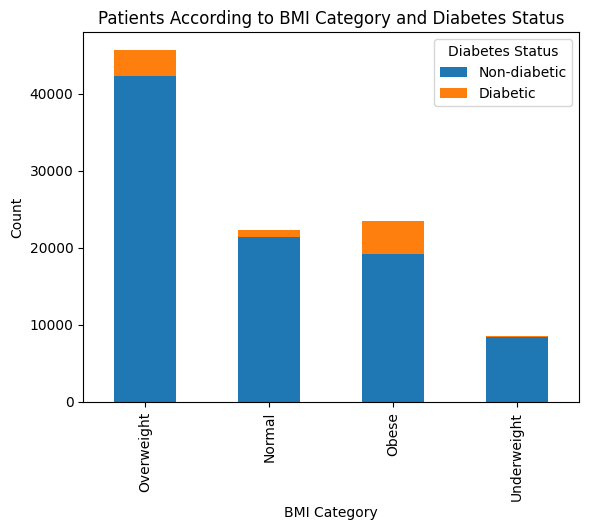

In [22]:
columns = ['Gender',
           'Race',
           'Age Group',
           'Hypertension',
           'Heart Disease',
           'Smoking History',
           'BMI Category']

for col in columns:

    categories = list(df2[col].unique())

    non_diabetic_counts = []
    diabetic_counts = []

    for cat in categories:

        non_diabetic = df2[(df2[col] == cat) & (df2["Diabetes"] == 0)].shape[0]
        diabetic = df2[(df2[col] == cat) & (df2["Diabetes"] == 1)].shape[0]

        non_diabetic_counts.append(non_diabetic)
        diabetic_counts.append(diabetic)

    d = pd.DataFrame({
        col: categories,
        "Non-diabetic": non_diabetic_counts,
        "Diabetic": diabetic_counts
    })

    if col == "Age Group":
        age_order = ["0-18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
        d['Age Group'] = pd.Categorical(d['Age Group'], categories = age_order, ordered=True)
        d_sorted = d.sort_values('Age Group')
        d_sorted.plot(x = col, kind = "bar", stacked = True)
        plt.title(f"Patients According to {col} and Diabetes Status")
        plt.xlabel(f"{col}")
        plt.ylabel("Count")
        plt.legend(title="Diabetes Status")
        plt.show()

    else:
        d.plot(x=col, kind="bar", stacked=True)
        plt.title(f"Patients According to {col} and Diabetes Status")
        plt.xlabel(f"{col}")
        plt.ylabel("Count")
        plt.legend(title="Diabetes Status")
        plt.show()

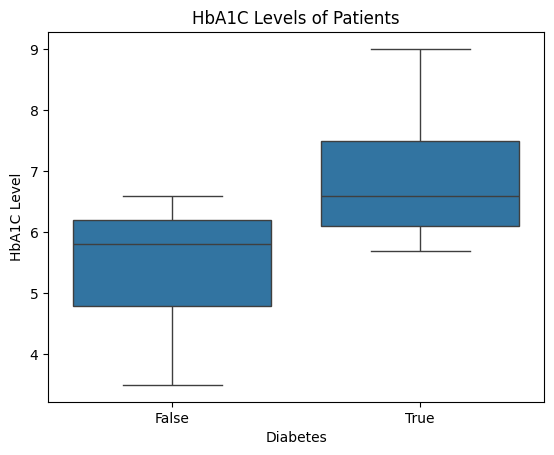

In [23]:
hd = sns.boxplot(data = df2, x = "Diabetes", y = "HbA1C Level")
hd.set_title("HbA1C Levels of Patients")
plt.show()

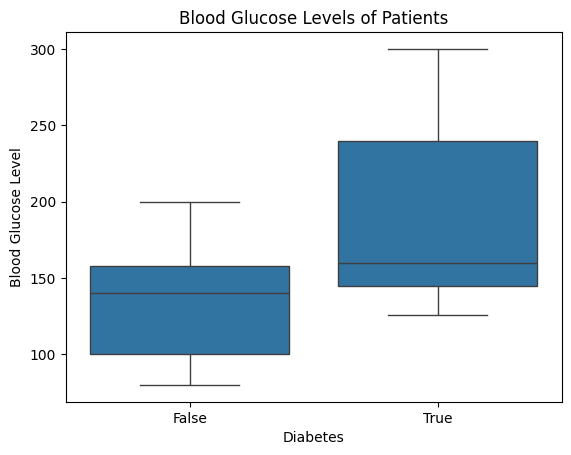

In [24]:
bgd = sns.boxplot(data = df2, x = "Diabetes", y = "Blood Glucose Level")
bgd.set_title("Blood Glucose Levels of Patients")
plt.show()

# Encoding Categorical Data

In [25]:
df_encoded = df2.drop(columns = "Age Group")
le = LabelEncoder()

df_encoded["Gender"] = le.fit_transform(df_encoded["Gender"])
df_encoded["Location"] = le.fit_transform(df_encoded["Location"])
df_encoded["Race"] = le.fit_transform(df_encoded["Race"])
df_encoded["BMI Category"] = le.fit_transform(df_encoded["BMI Category"])
df_encoded["Smoking History"] = le.fit_transform(df_encoded["Smoking History"])
df_encoded

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2020,0,4,32.0,0,False,False,3,2,27.32,5.0,100,False
1,2015,0,1,29.0,0,False,False,3,0,19.95,5.0,90,False
2,2015,1,4,18.0,0,False,False,3,0,23.76,4.8,160,False
3,2015,1,2,41.0,0,False,False,3,2,27.32,4.0,159,False
4,2016,0,0,52.0,0,False,False,3,0,23.75,6.5,90,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,0,4,33.0,54,False,False,3,0,21.21,6.5,90,False
99996,2016,0,1,80.0,54,False,False,4,1,36.66,5.7,100,False
99997,2018,1,1,46.0,54,False,False,1,1,36.12,6.2,158,False
99998,2018,0,0,51.0,54,False,False,5,2,29.29,6.0,155,False


In [26]:
corr_mat = df_encoded.corr()
corr_mat

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
Year,1.000000,0.001104,0.003852,-0.003304,-0.062219,-0.003806,0.001820,-0.000524,-0.001978,-0.001861,-0.000465,0.002968,-0.003464
Gender,0.001104,1.000000,-0.000254,-0.030656,-0.001573,0.014203,0.077696,-0.016127,0.097524,-0.022994,0.019957,0.017199,0.037411
Race,0.003852,-0.000254,1.000000,-0.003421,0.002335,-0.002677,-0.003563,-0.003481,-0.001186,-0.002497,0.001059,-0.004308,-0.006781
Age,-0.003304,-0.030656,-0.003421,1.000000,0.005388,0.251171,0.233354,-0.164931,-0.120291,0.337396,0.101354,0.110672,0.258008
Location,-0.062219,-0.001573,0.002335,0.005388,1.000000,0.005723,0.004388,0.003887,-0.000344,-0.000210,0.003106,0.002670,-0.000130
Hypertension,-0.003806,0.014203,-0.002677,0.251171,0.005723,1.000000,0.121262,-0.080178,-0.030421,0.147666,0.080939,0.084429,0.197823
Heart Disease,0.001820,0.077696,-0.003563,0.233354,0.004388,0.121262,1.000000,-0.054782,-0.014086,0.061198,0.067589,0.070066,0.171727
Smoking History,-0.000524,-0.016127,-0.003481,-0.164931,0.003887,-0.080178,-0.054782,1.000000,0.129721,-0.142483,-0.028493,-0.034982,-0.078029
BMI Category,-0.001978,0.097524,-0.001186,-0.120291,-0.000344,-0.030421,-0.014086,0.129721,1.000000,-0.113877,-0.011063,-0.008705,-0.032563
BMI,-0.001861,-0.022994,-0.002497,0.337396,-0.000210,0.147666,0.061198,-0.142483,-0.113877,1.000000,0.082997,0.091261,0.214357


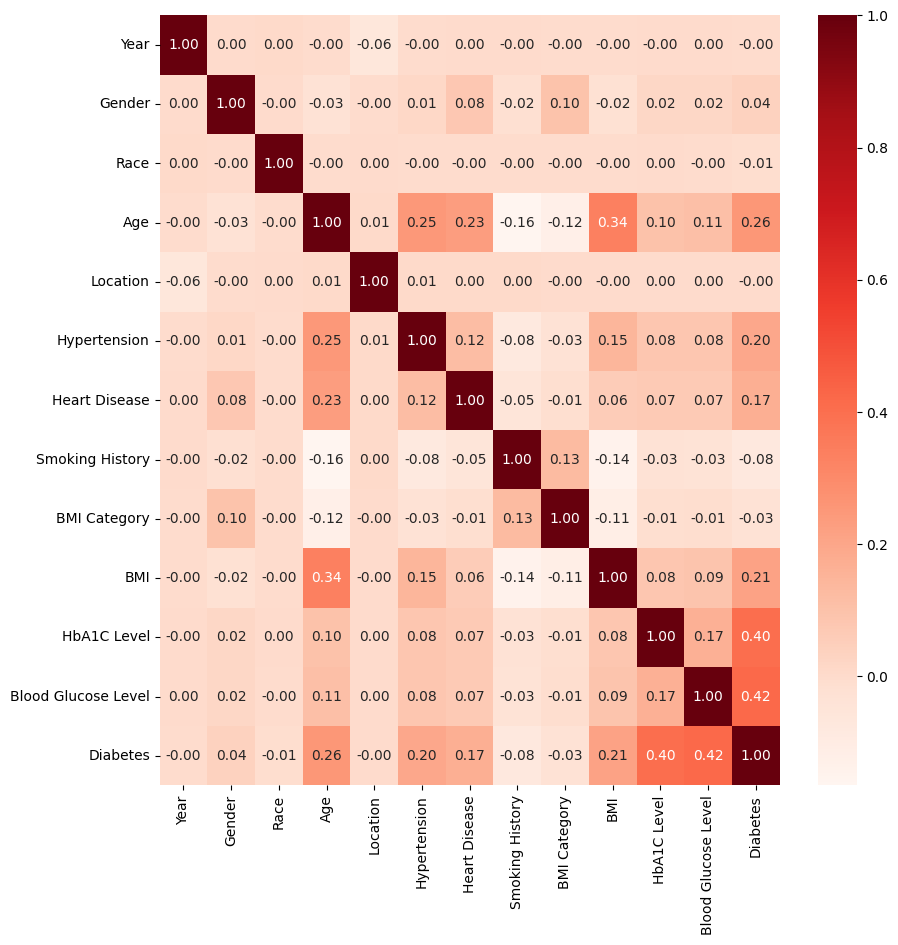

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot = True, cmap = "Reds", fmt='.2f')
plt.show()

# Drill-down Analysis

<ipython-input-28-51dbdadd4945>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


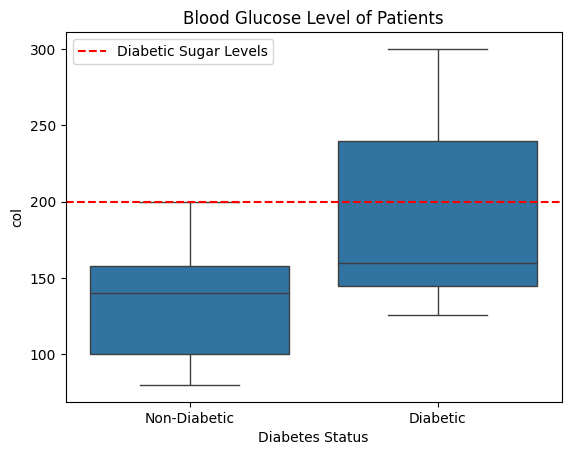

<ipython-input-28-51dbdadd4945>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


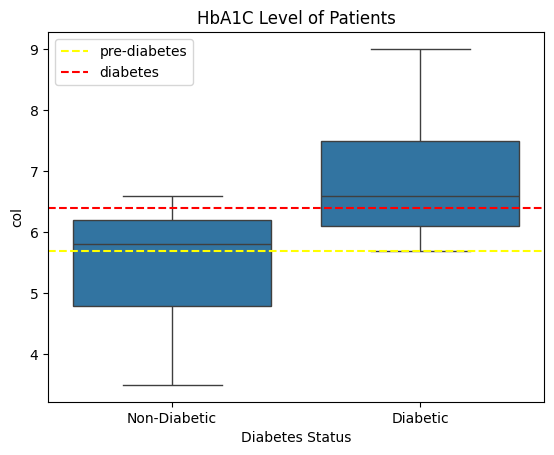

In [28]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    c = sns.boxplot(data = df2, x = "Diabetes", y = col)
    c.set_title(f"{col} of Patients")
    c.set_xlabel("Diabetes Status")
    c.set_ylabel(f"col")
    c.set_xticklabels(["Non-Diabetic", "Diabetic"])
    if col == "Blood Glucose Level":
        c.axhline(y = 200, c = "red", ls = "--", label = "Diabetic Sugar Levels")
    else:
        c.axhline(y = 5.7, c = "yellow", ls = "--",label = "pre-diabetes")
        c.axhline(y = 6.4, c = "red", ls = "--",label = "diabetes")
    c.legend()
    plt.show()

In [29]:
from scipy.stats import shapiro

columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:
    Nondiabetic = df2[df2["Diabetes"] == 0][col]
    Diabetic = df2[df2["Diabetes"] == 1][col]
    data = [Nondiabetic, Diabetic]
    for d in data:
        stats, pval = shapiro(d)
        if pval <= 0.05:
            print(f"The distribution of {col} is not normal.")
        else:
            print(f"The distribution of {col} is normal.")

The distribution of Blood Glucose Level is not normal.
The distribution of Blood Glucose Level is not normal.
The distribution of HbA1C Level is not normal.
The distribution of HbA1C Level is not normal.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 91500.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8500.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
from scipy.stats import mannwhitneyu

columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    stat, pval = mannwhitneyu(
        df2[df2["Diabetes"] == 1][col],
        df2[df2["Diabetes"] == 0][col], alternative = "greater")
    if pval > 0.05:
        print(f"p-value = {pval}. The {col} of patients with diabetes are not higher than those with diabetes.")
    else:
        print(f"p-value = {pval}. The {col} of patients with diabetes are higher than those with diabetes.")

p-value = 0.0. The Blood Glucose Level of patients with diabetes are higher than those with diabetes.
p-value = 0.0. The HbA1C Level of patients with diabetes are higher than those with diabetes.


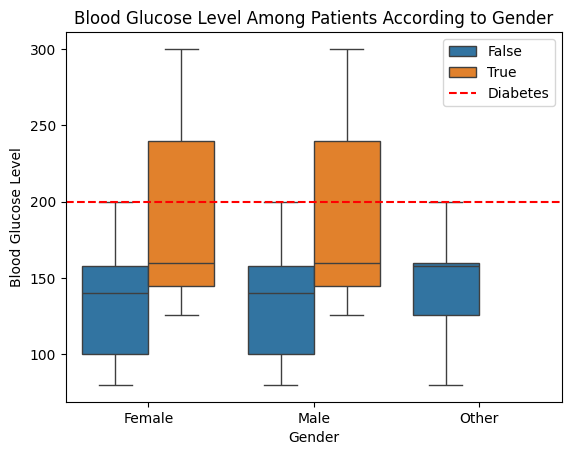

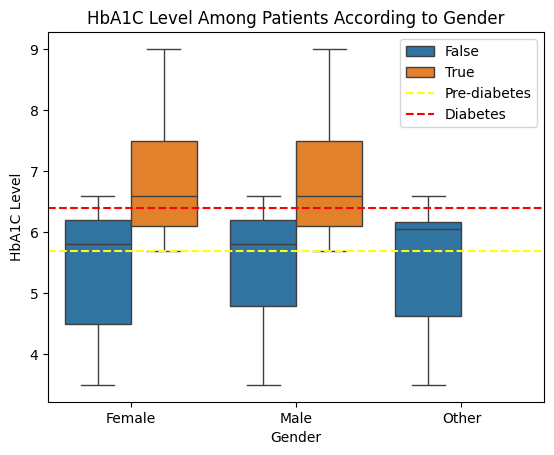

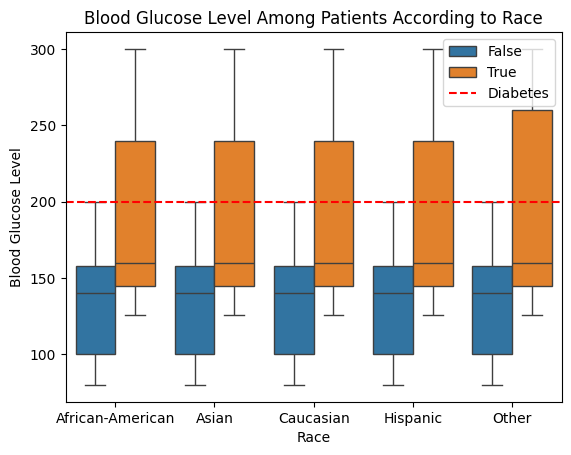

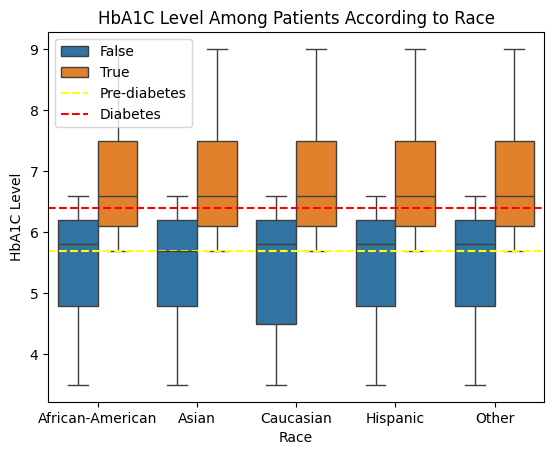

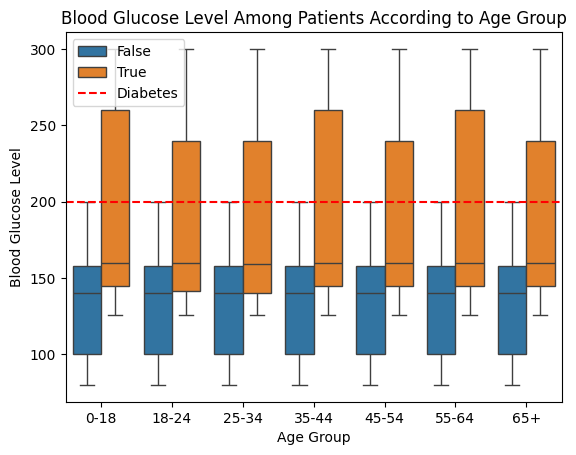

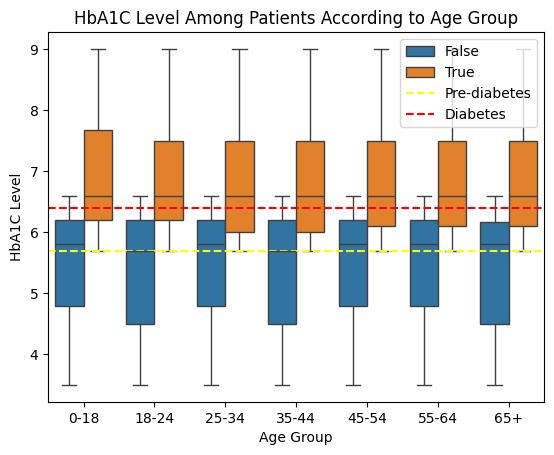

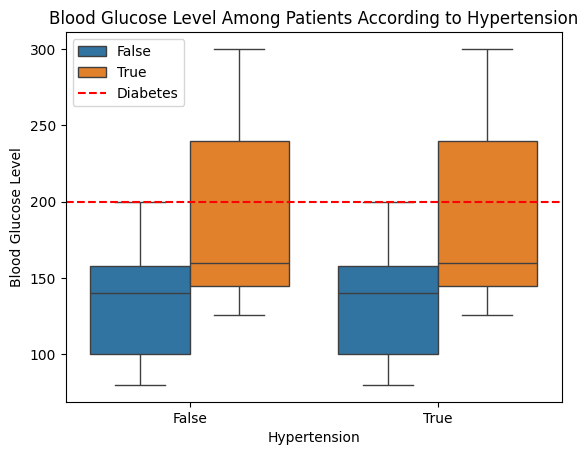

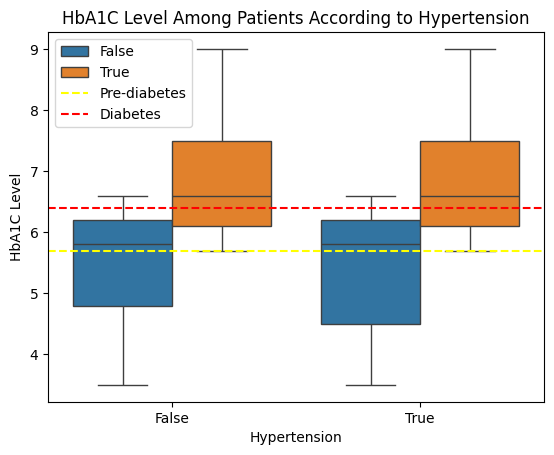

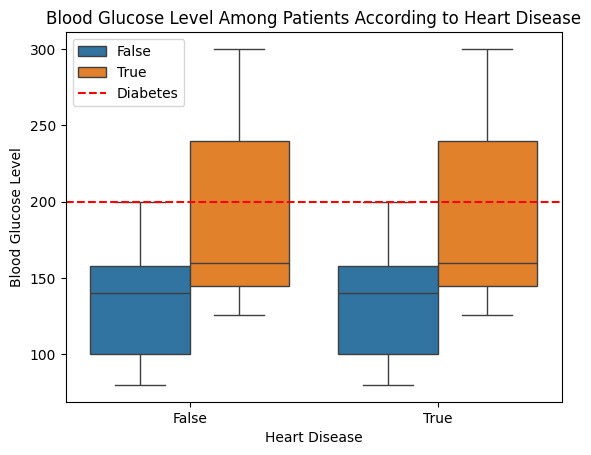

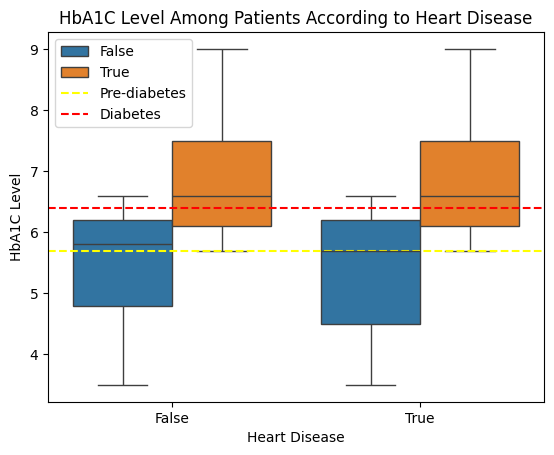

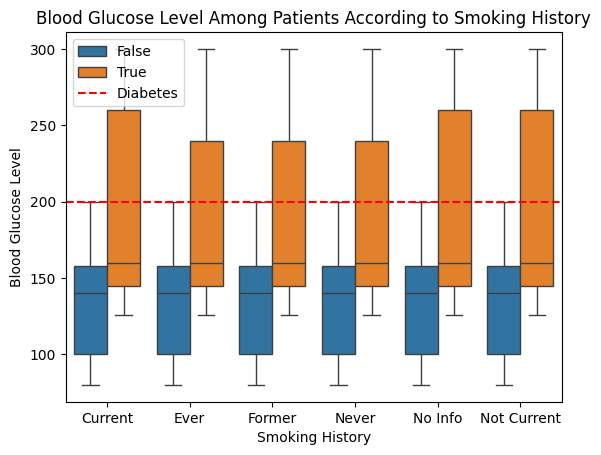

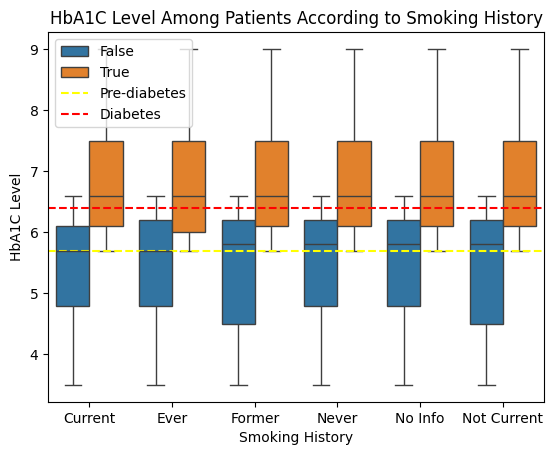

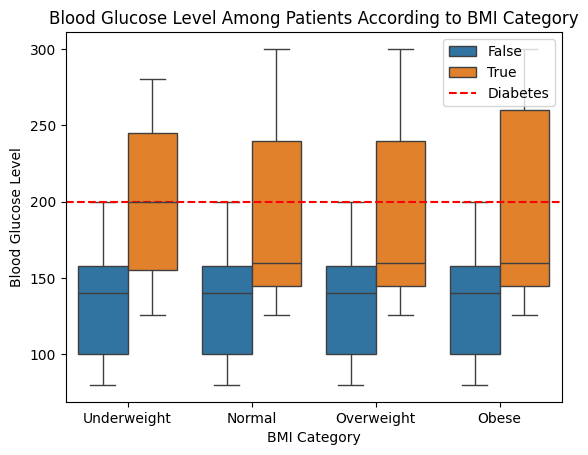

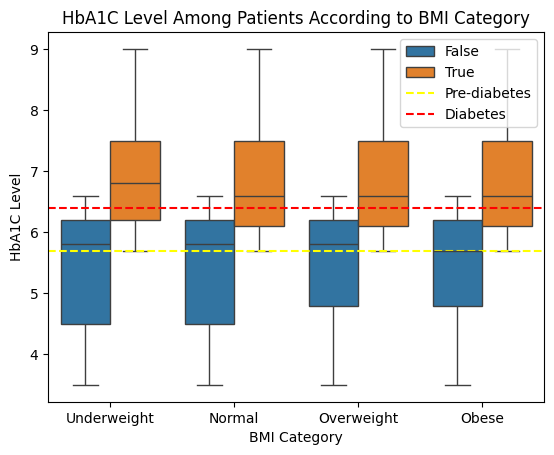

In [31]:
columns = ["Gender",
           "Race",
           "Age Group",
           "Hypertension",
           "Heart Disease",
           "Smoking History",
           "BMI Category"]

targets = ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    for target in targets:

        h = sns.boxplot(data = df2, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")
        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":

            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:

            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

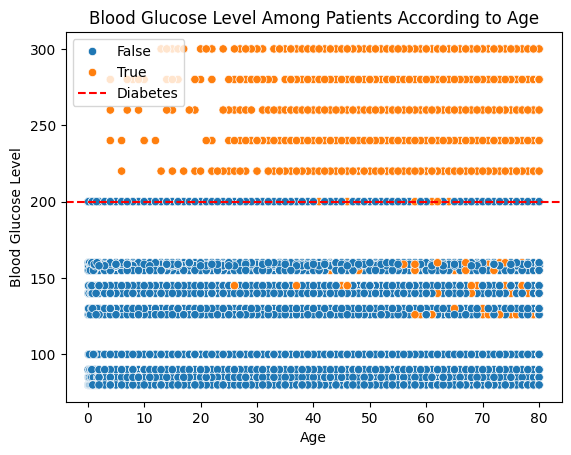

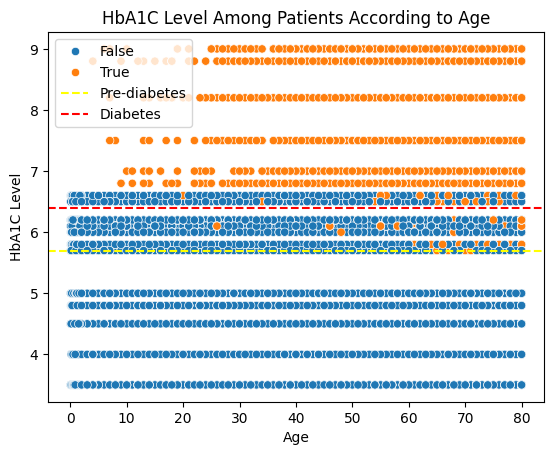

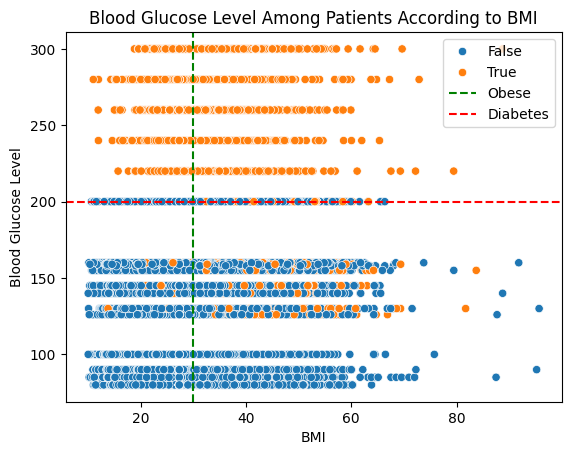

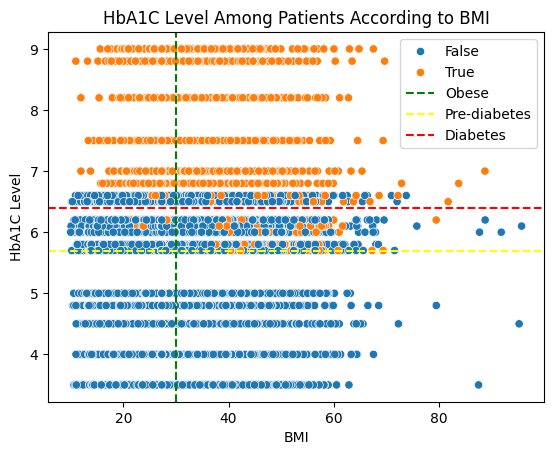

In [32]:
columns = ["Age", "BMI"]
targets = ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    for target in targets:

        h = sns.scatterplot(data = df2, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")

        if col == "BMI":
            h.axvline(x = 30, c = "green", ls = "--",label = "Obese")

        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":
            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:
            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

In [33]:
columns = ['Gender',
           'Race',
           'Age Group',
           'Location',
           'Hypertension',
           'Heart Disease',
           'Smoking History',
           'BMI Category']

from scipy.stats import chi2_contingency, chi2

for col in columns:

    contingency_table  = pd.crosstab(df2[col], df2["Diabetes"])
    chi_square, p, dof, expected = chi2_contingency(contingency_table)
    critical_value = chi2.ppf(1 - 0.05, dof)

    if chi_square <= critical_value:
        print(f"There is no relationship between {col} and diabetes.")

    else:
        print(f"There is a relationship between {col} and diabetes.")

There is a relationship between Gender and diabetes.
There is no relationship between Race and diabetes.
There is a relationship between Age Group and diabetes.
There is no relationship between Location and diabetes.
There is a relationship between Hypertension and diabetes.
There is a relationship between Heart Disease and diabetes.
There is a relationship between Smoking History and diabetes.
There is a relationship between BMI Category and diabetes.


In [34]:
columns = ['Gender',
           'Age Group',
           'Hypertension',
           'Heart Disease',
           'Smoking History',
           'BMI Category']

for col in columns:

    contingency_table  = pd.crosstab(df2[col], df2["Diabetes"])
    contingency_table["total"] = contingency_table[False] + contingency_table[True]
    contingency_table["risk"] = contingency_table[True] / contingency_table["total"]
    risk_A_label = contingency_table["risk"].idxmax()
    risk_A = contingency_table.loc[risk_A_label, "risk"]
    risk_B = contingency_table.loc[contingency_table.index != risk_A_label, "risk"].mean()
    rr = round(risk_A/risk_B, 2)

    if col == "Age Group":
        print(f"Ages {risk_A_label}: {rr} times more likely to develop diabetes.")

    elif col in ["Hypertension", "Heart Disease"]:
        if risk_A_label == True:
            print(f"People with {col}: {rr} times more likely to develop diabetes.")
        else:
            print(f"People without {col}: {rr} times more likely to develop diabetes.")

    elif col == "Smoking History":
        print(f"{risk_A_label} smokers: {rr} times more likely to develop diabetes.")

    elif col == "BMI Category":
        print(f"{risk_A_label} people: {rr} times more likely to develop diabetes.")

    else:
        print(f"{risk_A_label}: {rr} times more likely to develop diabetes.")

Male: 2.56 times more likely to develop diabetes.
Ages 65+: 3.45 times more likely to develop diabetes.
People with Hypertension: 4.02 times more likely to develop diabetes.
People with Heart Disease: 4.27 times more likely to develop diabetes.
Former smokers: 1.84 times more likely to develop diabetes.
Obese people: 4.53 times more likely to develop diabetes.


# Splitting the Data into Training and Test Sets

In [35]:
X = df_encoded.drop(columns = ["Year", "Diabetes", "BMI Category"])
y = df_encoded["Diabetes"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Feature Scaling

In [36]:
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Logistic Regression

In [37]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)
y_logit = logit.predict(X_test_scaled)
acc_logit = accuracy_score(y_logit, y_test)
class_rep_logit = classification_report(y_logit, y_test)
print("accuracy: ", acc_logit)
print(class_rep_logit)

accuracy:  0.9606
              precision    recall  f1-score   support

       False       0.99      0.97      0.98     18779
        True       0.63      0.87      0.73      1221

    accuracy                           0.96     20000
   macro avg       0.81      0.92      0.85     20000
weighted avg       0.97      0.96      0.96     20000



# Decision Tree

In [38]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_scaled, y_train)
y_tree = tree.predict(X_test_scaled)
acc_tree = accuracy_score(y_tree, y_test)
class_rep_tree = classification_report(y_tree, y_test)
print("accuracy: ", acc_tree)
print(class_rep_tree)

accuracy:  0.95035
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     18222
        True       0.73      0.70      0.71      1778

    accuracy                           0.95     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.95      0.95      0.95     20000



# Random Forest

In [39]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_scaled, y_train)
y_rf = rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_rf, y_test)
class_rep_rf = classification_report(y_rf, y_test)
print("accuracy: ", acc_rf)
print(class_rep_rf)

accuracy:  0.9717
              precision    recall  f1-score   support

       False       1.00      0.97      0.98     18813
        True       0.68      0.98      0.80      1187

    accuracy                           0.97     20000
   macro avg       0.84      0.98      0.89     20000
weighted avg       0.98      0.97      0.97     20000

